In [1]:
from tqdm import tqdm
from etnn.nn.baseline import create_baseline_model, calc_params
import pandas as pd
import os
from sklearn.metrics import r2_score
from etnn.tools.training import train_epoch, eval_epoch
from etnn import TreeNode
from etnn.nn.layer_framework import LayerManagementFramework
from etnn.routines.run_config import choice_trainloader, choice_loss, choice_optim
import torch
from torch.utils.data import random_split, DataLoader
from etnn.data.ferris_wheel import load_pure_ferris_wheel_dataset_single_node
from etnn.tools.training_tools import ConfigStore, seeding_all
import matplotlib.pyplot as plt

In [2]:
dataset_path = "../../datasets/"
test_perc = 0.3
stability_count = 5
label = "tree-advanced" # although irrelevant

In [3]:
def create_plot(
        df,
        what: str = "r2"
) -> None:
    plt.figure()

    # Plot the initial data
    for config_id in df.config_id.unique():
        # make subdataset for config id
        sub_df = df[df.config_id == config_id]
        # plot train test and val
        for mode in ['train', 'test', 'val']:
            # plot training
            if f"{mode}_{what}" in sub_df.columns:
                plt.plot(sub_df.epoch, sub_df[f"{mode}_{what}"], label=f"{config_id}_{mode}-{what}")

    plt.title(f"{what} plot")
    plt.xlabel("epoch")
    plt.ylabel("score")
    if what == "r2":
        plt.ylim(-1, +1)
    plt.legend()
    plt.show()

In [4]:
def run(i, entry, size_elem, normalized, node_type):
    # init default config
    config = ConfigStore(
        in_dim=15,
        hidden_dim=int(entry.params_hidden_dim),
        out_dim=1,
        k=int(entry.params_k),
        dataset=-1 if normalized else 0,
        ds_size=10_000,
        num_gondolas=-1,
        num_part_pg=-1,
        loss_name='mse',
        optimizer_name='adam',
        num_max_epochs=300, # real: 100
        learning_rate=float(entry.params_learning_rate),
        batch_size=1024,
        early_stop_tol=5,
        use_equal_batcher=bool(entry.params_batcher),
        seed=420,
        label_type=label,
        final_label_factor=5/1000
    )

    # loading dataset
    dataset, df_index = load_pure_ferris_wheel_dataset_single_node(
        node_type=node_type,
        num_elem=size_elem,
        num_to_generate=config.ds_size,
        dataset_path=dataset_path,
        final_label_factor=config.final_label_factor,
        normalize=True if config.dataset == -1 else 0
    )
    # splitting off test dataset
    generator = torch.Generator().manual_seed(config.seed)
    train_ds, test_ds= random_split(
        dataset,
        [1 - test_perc, test_perc],
        generator=generator
    )

    # loaders
    train_loader = choice_trainloader(config, df_index, train_ds)
    test_loader = DataLoader(test_ds, batch_size=4 * config.batch_size, shuffle=False)

    # define device
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # set seed for reproducability
    seeding_all(config.seed)

    # define model
    model = LayerManagementFramework(
        in_dim=config.in_dim,
        tree=TreeNode(node_type, [TreeNode("E", size_elem)]),
        hidden_dim=config.hidden_dim,
        out_dim=config.out_dim,
        k=config.k
    ).to(device)

    # learning tools
    criterion = choice_loss(config)
    optimizer = choice_optim(config, model)

    # init score list
    train_r2_list = []
    test_r2_list = []
    train_loss_list = []
    test_loss_list = []

    file_name = f"single-node_node-type-{node_type}_rank-{i}_normalized-{normalized}_n-{size_elem}.csv"
    if os.path.isfile(file_name):
        df = pd.read_csv(file_name)
    else:
        # train for specified number of epochs
        for epoch in tqdm(range(config.num_max_epochs)):
            train_loss, train_true_y, train_pred_y = train_epoch(
                model,
                train_loader,
                optimizer,
                device,
                criterion
            )

            test_loss, test_true_y, test_pred_y = eval_epoch(
                model,
                test_loader,
                device,
                criterion
            )

            # calc r2 score and append
            train_r2_list += [r2_score(y_true=train_true_y, y_pred=train_pred_y)]
            test_r2_list += [r2_score(y_true=test_true_y, y_pred=test_pred_y)]
            train_loss_list += [train_loss.item()]
            test_loss_list += [test_loss.item()]

        # REPEAT FOR BASELINE MODEL
        seeding_all(config.seed)
        # %%
        model, _ = create_baseline_model(
            n_params=calc_params(model),
            input_dim=config.in_dim * size_elem,
            n_layer=3,
            output_dim=1
        )
        model = model.to(device)

        optimizer = choice_optim(config, model)

        # train for N epochs
        for epoch in tqdm(range(config.num_max_epochs)):
            train_loss, train_true_y, train_pred_y = train_epoch(
                model,
                train_loader,
                optimizer,
                device,
                criterion
            )

            test_loss, test_true_y, test_pred_y = eval_epoch(
                model,
                test_loader,
                device,
                criterion
            )

            # calc r2 score and append
            train_r2_list += [r2_score(y_true=train_true_y, y_pred=train_pred_y)]
            test_r2_list += [r2_score(y_true=test_true_y, y_pred=test_pred_y)]
            train_loss_list += [train_loss.item()]
            test_loss_list += [test_loss.item()]

        df = pd.DataFrame({
            "config_id": ["etnn"]*config.num_max_epochs + ["baseline"]*config.num_max_epochs,
            "epoch": list(range(1, config.num_max_epochs + 1))*2,
            "train_loss": train_loss_list,
            "test_loss": test_loss_list,
            "train_r2": train_r2_list,
            "test_r2": test_r2_list
        })
        df.to_csv(file_name)

    # plotting
    create_plot(df, "r2")
    create_plot(df, "loss")

# S

Rank 1 parameter configuration: Unnamed: 0                                      19
number                                          19
value                                      0.88093
datetime_start          2023-12-10 17:17:40.490020
datetime_complete       2023-12-10 17:19:24.879322
duration                    0 days 00:01:44.389302
params_batcher                               False
params_hidden_dim                              368
params_k                                         1
params_learning_rate                      0.000036
state                                     COMPLETE
Name: 19, dtype: object


100%|██████████| 300/300 [20:04<00:00,  4.02s/it]


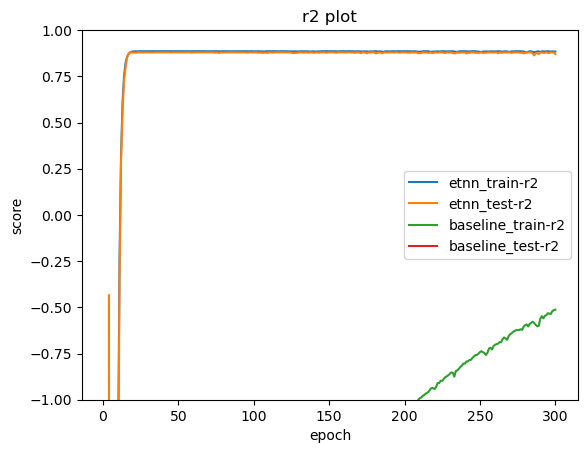

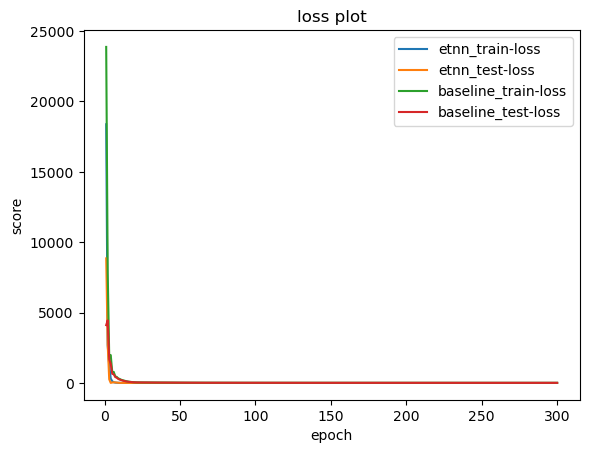

Rank 2 parameter configuration: Unnamed: 0                                      37
number                                          37
value                                     0.877838
datetime_start          2023-12-10 17:47:21.653632
datetime_complete       2023-12-10 17:48:45.030330
duration                    0 days 00:01:23.376698
params_batcher                               False
params_hidden_dim                              432
params_k                                         1
params_learning_rate                      0.000027
state                                     COMPLETE
Name: 37, dtype: object


100%|██████████| 300/300 [17:17<00:00,  3.46s/it]


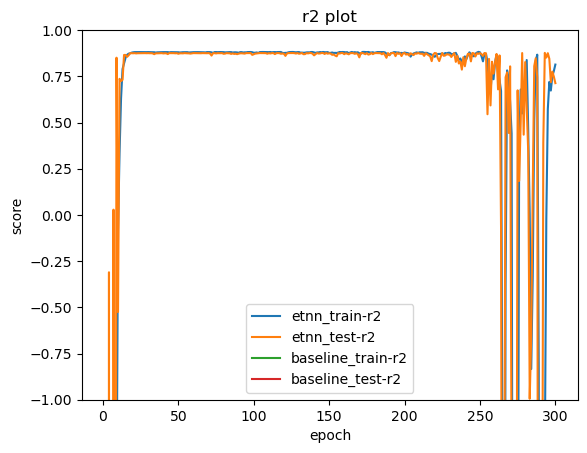

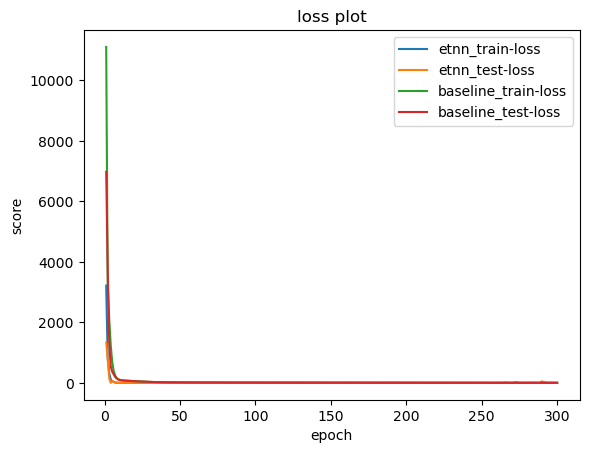

Rank 3 parameter configuration: Unnamed: 0                                      43
number                                          43
value                                     0.872702
datetime_start          2023-12-10 17:56:34.261690
datetime_complete       2023-12-10 17:58:03.869197
duration                    0 days 00:01:29.607507
params_batcher                               False
params_hidden_dim                              272
params_k                                         1
params_learning_rate                      0.000024
state                                     COMPLETE
Name: 43, dtype: object


100%|██████████| 300/300 [18:08<00:00,  3.63s/it]


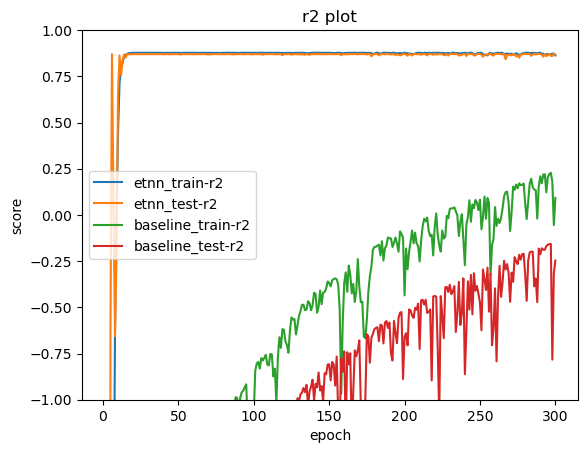

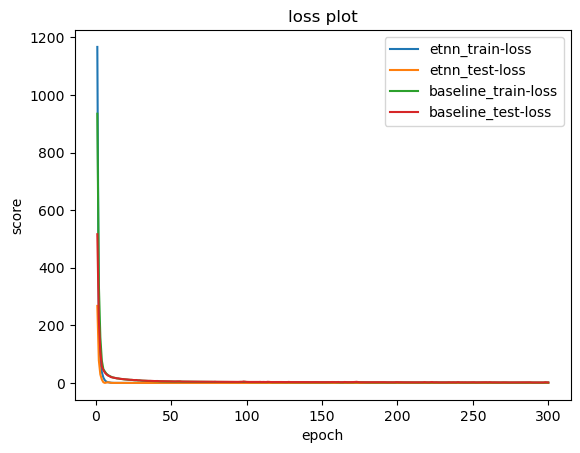

In [5]:
normalized = False
size_elem = 10
node_type = "S"

config_table = pd.read_csv(f"single-node_t-{node_type}_n-{size_elem}_normalized-{normalized}.csv")

# sort config storage
config_table = config_table.sort_values(by=['value'], ascending=False)

# iterate over top 3 best configs
for i in range(3):
    # get entry from dataframe
    entry = config_table.iloc[i]

    # print information to console
    print(f"Rank {i+1} parameter configuration: {entry}")

    run(i, entry, size_elem, normalized, node_type)

Rank 1 parameter configuration: Unnamed: 0                                      24
number                                          24
value                                     0.991843
datetime_start          2023-12-10 18:35:43.193866
datetime_complete       2023-12-10 18:36:54.415164
duration                    0 days 00:01:11.221298
params_batcher                               False
params_hidden_dim                              336
params_k                                         3
params_learning_rate                      0.003167
state                                     COMPLETE
Name: 24, dtype: object


100%|██████████| 300/300 [18:30<00:00,  3.70s/it]


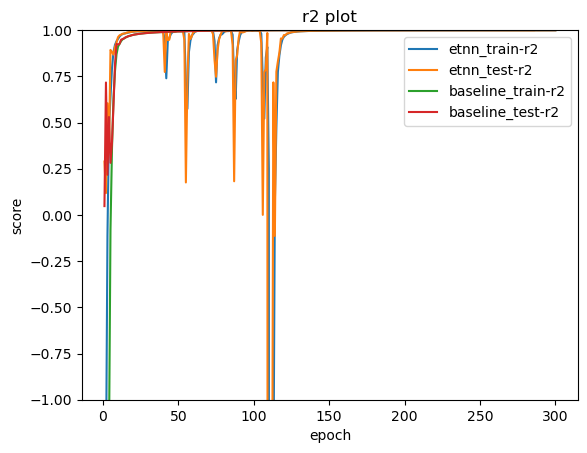

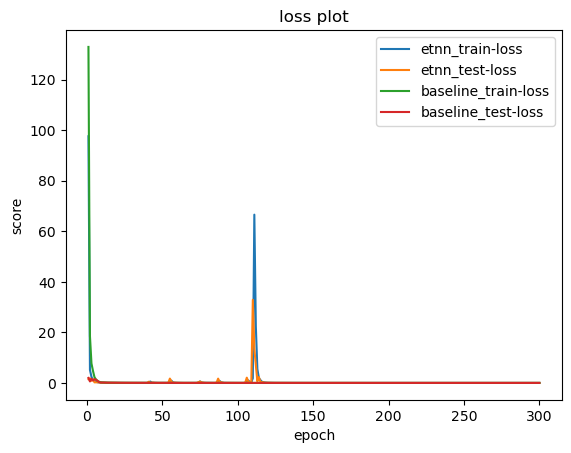

Rank 2 parameter configuration: Unnamed: 0                                      46
number                                          46
value                                     0.990504
datetime_start          2023-12-10 19:01:18.542318
datetime_complete       2023-12-10 19:02:28.487124
duration                    0 days 00:01:09.944806
params_batcher                               False
params_hidden_dim                              352
params_k                                         3
params_learning_rate                       0.00219
state                                     COMPLETE
Name: 46, dtype: object


 11%|█         | 33/300 [01:46<13:44,  3.09s/it]

In [ ]:
normalized = True
size_elem = 10
node_type = "S"

config_table = pd.read_csv(f"single-node_t-{node_type}_n-{size_elem}_normalized-{normalized}.csv")

# sort config storage
config_table = config_table.sort_values(by=['value'], ascending=False)

# iterate over top 3 best configs
for i in range(3):
    # get entry from dataframe
    entry = config_table.iloc[i]

    # print information to console
    print(f"Rank {i+1} parameter configuration: {entry}")

    run(i, entry, size_elem, normalized, node_type)

# Q

In [ ]:
normalized = False
size_elem = 10
node_type = "Q"

config_table = pd.read_csv(f"single-node_t-{node_type}_n-{size_elem}_normalized-{normalized}.csv")

# sort config storage
config_table = config_table.sort_values(by=['value'], ascending=False)

# iterate over top 3 best configs
for i in range(3):
    # get entry from dataframe
    entry = config_table.iloc[i]

    # print information to console
    print(f"Rank {i+1} parameter configuration: {entry}")

    run(i, entry, size_elem, normalized, node_type)

In [ ]:
normalized = True
size_elem = 10
node_type = "Q"

config_table = pd.read_csv(f"single-node_t-{node_type}_n-{size_elem}_normalized-{normalized}.csv")

# sort config storage
config_table = config_table.sort_values(by=['value'], ascending=False)

# iterate over top 3 best configs
for i in range(3):
    # get entry from dataframe
    entry = config_table.iloc[i]

    # print information to console
    print(f"Rank {i+1} parameter configuration: {entry}")

    run(i, entry, size_elem, normalized, node_type)

# C

In [ ]:
normalized = False
size_elem = 10
node_type = "C"

config_table = pd.read_csv(f"single-node_t-{node_type}_n-{size_elem}_normalized-{normalized}.csv")

# sort config storage
config_table = config_table.sort_values(by=['value'], ascending=False)

# iterate over top 3 best configs
for i in range(3):
    # get entry from dataframe
    entry = config_table.iloc[i]

    # print information to console
    print(f"Rank {i+1} parameter configuration: {entry}")

    run(i, entry, size_elem, normalized, node_type)

In [ ]:
normalized = True
size_elem = 10
node_type = "C"

config_table = pd.read_csv(f"single-node_t-{node_type}_n-{size_elem}_normalized-{normalized}.csv")

# sort config storage
config_table = config_table.sort_values(by=['value'], ascending=False)

# iterate over top 3 best configs
for i in range(3):
    # get entry from dataframe
    entry = config_table.iloc[i]

    # print information to console
    print(f"Rank {i+1} parameter configuration: {entry}")

    run(i, entry, size_elem, normalized, node_type)

# P

In [ ]:
normalized = False
size_elem = 10
node_type = "P"

config_table = pd.read_csv(f"single-node_t-{node_type}_n-{size_elem}_normalized-{normalized}.csv")

# sort config storage
config_table = config_table.sort_values(by=['value'], ascending=False)

# iterate over top 3 best configs
for i in range(3):
    # get entry from dataframe
    entry = config_table.iloc[i]

    # print information to console
    print(f"Rank {i+1} parameter configuration: {entry}")

    run(i, entry, size_elem, normalized, node_type)

In [ ]:
normalized = True
size_elem = 10
node_type = "S"

config_table = pd.read_csv(f"single-node_t-{node_type}_n-{size_elem}_normalized-{normalized}.csv")

# sort config storage
config_table = config_table.sort_values(by=['value'], ascending=False)

# iterate over top 3 best configs
for i in range(3):
    # get entry from dataframe
    entry = config_table.iloc[i]

    # print information to console
    print(f"Rank {i+1} parameter configuration: {entry}")

    run(i, entry, size_elem, normalized, node_type)